In [250]:
import pandas as pd

# Load the dataset
df = pd.read_csv("GBPJPY.csv")

df.head()


,Date,Value
0,01/02/1991,261.39
1,01/03/1991,259.40
2,01/04/1991,261.00
3,01/07/1991,259.41
4,01/08/1991,259.18


In [251]:
df = df.rename(columns={
    "Date": "date",
    "Value": "close"
})


In [252]:
df["date"] = pd.to_datetime(df["date"])


In [253]:
#Sort the Data by Date
df = df.sort_values("date").reset_index(drop=True)



In [254]:
#Filter the Project Date Range (2019–2025)
df = df[
    (df["date"] >= "2019-01-01") &
    (df["date"] <= "2025-12-31")
].reset_index(drop=True)
df.head()
df.tail()





,date,close
2290,2025-12-26,211.3763
2291,2025-12-27,211.3763
2292,2025-12-29,210.7231
2293,2025-12-30,210.5896
2294,2025-12-31,210.9597


In [255]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295 entries, 0 to 2294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2295 non-null   datetime64[ns]
 1   close   2295 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 36.0 KB


,close
count,2295.000000
mean,166.096591
std,23.488863
min,125.757800
25%,143.790500
50%,162.203400
75%,189.490000
max,211.410200


In [256]:
#creating daily returns
df["return_1d"] = df["close"].pct_change()
df.head()


,date,close,return_1d
0,2019-01-01,139.7287,NaN
1,2019-01-02,133.1783,-0.046879
2,2019-01-03,136.0483,0.021550
3,2019-01-04,138.1593,0.015517
4,2019-01-05,138.1593,0.000000


In [257]:
df["ma_1"] = df["close"].rolling(window=1).mean()
df["ma_5"] = df["close"].rolling(window=5).mean()
df["ma_20"] = df["close"].rolling(window=20).mean()
df["ma_50"] = df["close"].rolling(window=50).mean()


In [258]:
df[["close", "ma_1", "ma_5", "ma_20", "ma_50"]].head(10)


,close,ma_1,ma_5,ma_20,ma_50
0,139.7287,139.7287,NaN,NaN,NaN
1,133.1783,133.1783,NaN,NaN,NaN
2,136.0483,136.0483,NaN,NaN,NaN
3,138.1593,138.1593,NaN,NaN,NaN
4,138.1593,138.1593,137.05478,NaN,NaN
5,138.9362,138.9362,136.89628,NaN,NaN
6,138.3380,138.3380,137.92822,NaN,NaN
7,138.3850,138.3850,138.39556,NaN,NaN
8,138.2492,138.2492,138.41354,NaN,NaN
9,139.5087,139.5087,138.68342,NaN,NaN


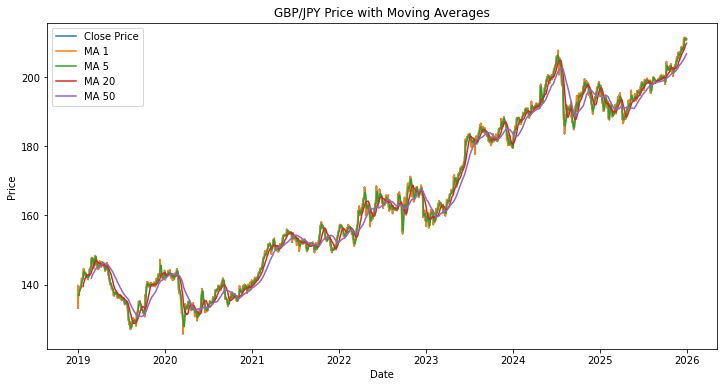

In [259]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df["date"], df["close"], label="Close Price")
plt.plot(df["date"], df["ma_1"], label="MA 1")
plt.plot(df["date"], df["ma_5"], label="MA 5")
plt.plot(df["date"], df["ma_20"], label="MA 20")
plt.plot(df["date"], df["ma_50"], label="MA 50")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("GBP/JPY Price with Moving Averages")
plt.legend()
plt.show()


In [260]:
#defining future returns
df["future_return_1d"] = df["return_1d"].shift(-1)





In [261]:
# DEFINING THRESHOLDS
buy_threshold = 0.002   # +0.2%
sell_threshold = -0.002  # -0.2%



In [262]:
#CREATING THE SIGNAL LABEL
def classify_signal(x):
    if x > buy_threshold:
        return "BUY"
    elif x < sell_threshold:
        return "SELL"
    else:
        return "HOLD"

df["signal"] = df["future_return_1d"].apply(classify_signal)



In [263]:
df["signal"].value_counts(normalize=True)


HOLD    0.446623
BUY     0.294989
SELL    0.258388
Name: signal, dtype: float64

In [264]:
# trend features
df["above_ma_5"] = (df["close"] > df["ma_5"]).astype(int)
df["above_ma_20"] = (df["close"] > df["ma_20"]).astype(int)
df["above_ma_50"] = (df["close"] > df["ma_50"]).astype(int)


In [265]:
# Moving Average Cross Strength,Measures trend momentum.
df["ma_5_20_diff"] = df["ma_5"] - df["ma_20"]
df["ma_20_50_diff"] = df["ma_20"] - df["ma_50"]




In [266]:
# Short-term momentum 
df["return_5d"] = df["close"].pct_change(5)
df["return_20d"] = df["close"].pct_change(20)


In [267]:
# risk features ,rolling volatilty
df["volatility_5d"] = df["return_1d"].rolling(5).std()
df["volatility_20d"] = df["return_1d"].rolling(20).std()


In [268]:
#High Risk vs Low Risk Flag
vol_threshold = df["volatility_20d"].median()
df["high_risk"] = (df["volatility_20d"] > vol_threshold).astype(int)


In [269]:
# Breakout Detection
df["rolling_high_20"] = df["close"].rolling(20).max()
df["breakout"] = (df["close"] > df["rolling_high_20"].shift(1)).astype(int)


In [270]:
# Clean Missing Values
df = df.dropna().reset_index(drop=True)


In [271]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2245 entries, 0 to 2244
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2245 non-null   datetime64[ns]
 1   close             2245 non-null   float64       
 2   return_1d         2245 non-null   float64       
 3   ma_1              2245 non-null   float64       
 4   ma_5              2245 non-null   float64       
 5   ma_20             2245 non-null   float64       
 6   ma_50             2245 non-null   float64       
 7   future_return_1d  2245 non-null   float64       
 8   signal            2245 non-null   object        
 9   above_ma_5        2245 non-null   int32         
 10  above_ma_20       2245 non-null   int32         
 11  above_ma_50       2245 non-null   int32         
 12  ma_5_20_diff      2245 non-null   float64       
 13  ma_20_50_diff     2245 non-null   float64       
 14  return_5d         2245 n

In [272]:
#SELECT FEATURE COLUMNS
feature_cols = [
    "return_1d",
    "return_5d",
    "return_20d",
    "ma_5",
    "ma_20",
    "ma_50",
    "above_ma_5",
    "above_ma_20",
    "above_ma_50",
    "ma_5_20_diff",
    "ma_20_50_diff",
    "volatility_5d",
    "volatility_20d",
    "high_risk",
    "breakout"
]


In [273]:
#Create X and y
X = df[feature_cols]
y = df["signal"]


In [274]:
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]


In [275]:
X_train.shape, X_test.shape
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


HOLD    0.467706
BUY     0.296214
SELL    0.236080
Name: signal, dtype: float64

In [276]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [277]:
#TRAIN THE MODEL
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

log_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [278]:
# market predictions
y_pred = log_model.predict(X_test_scaled)

In [279]:
# accuracy check
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)


0.46770601336302897

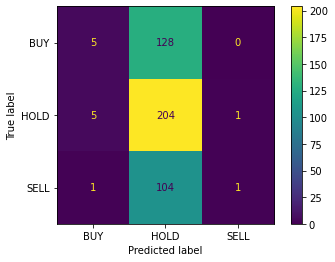

In [280]:
# model evaluation,CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=["BUY", "HOLD", "SELL"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["BUY", "HOLD", "SELL"]
)

disp.plot()
plt.show()


In [281]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [282]:
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=40,
    class_weight="balanced",
    random_state=42
)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=40, random_state=42)

In [284]:
y_pred_dt = dt_model.predict(X_test)


In [285]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)


array([[25, 78, 30],
       [48, 97, 65],
       [19, 53, 34]], dtype=int64)